# 📌 **Project Overview**

This project performs customer segmentation using RFM (Recency, Frequency, Monetary) analysis on retail transaction data.

The goal is to:
- ``Identify high-value customers``
- ``Detect customers at risk of churning``
- ``Help businesses make informed marketing decisions``

## Import Necessary Libaries

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

#For unzipping file
from zipfile import ZipFile

## Loading and checking data

In [3]:
#unzip data
with ZipFile('content/data.csv.zip', 'r') as zip_ref:
    zip_ref.extractall("/content/data/")

In [4]:
# Load dataset
df = pd.read_csv('/content/data/data.csv', encoding='latin-1')

#create function to preview data
def check_data(df):
  # Quick preview
  print(df.head())

  # Data structure
  print(df.info())

  # Check for nulls
  print(df.isnull().sum())

  #check for duplicate
  print('Duplicated:', df.duplicated().sum())

check_data(df)

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo   

## Cleaning Data

In [5]:
#define function to clean data
def wrangle_data(df):
  df_clean = df.copy()
    # Convert InvoiceDate to datetime
  df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'], errors='coerce')

    # Drop rows with missing CustomerID
  df_clean.dropna(subset=['CustomerID'], inplace=True)

    # Remove rows with zero or negative values
  df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

    # Drop duplicates
  df_clean.drop_duplicates(inplace=True)

    # Add TotalPrice column
  df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

    # Convert data types
  df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)

  #reset index
  df_clean.reset_index(drop=True, inplace=True)

  return df_clean

#clean df
df_clean = wrangle_data(df)

In [6]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392692 entries, 0 to 392691
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  int64         
 7   Country      392692 non-null  object        
 8   TotalPrice   392692 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 27.0+ MB


## RFM Metrics calculation

In [7]:
# Set reference date (1 day after last purchase)
reference_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate RFM values
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm.sort_values('Monetary', ascending=False).head()

,CustomerID,Recency,Frequency,Monetary
1689,14646,2,73,280206.02
4201,18102,1,60,259657.30
3728,17450,8,46,194390.79
3008,16446,1,2,168472.50
1879,14911,1,201,143711.17


This is RFM metrics (Recency, Frequency, and Monetary value) calculated for each customer based on their purchase behavior.

Recency: Number of days since the customer’s last purchase (relative to a reference date).

Frequency: Total number of distinct purchase transactions (InvoiceNo) made by the customer.

Monetary: Total amount spent (Quantity × UnitPrice) across all purchases.

The reference date defaults to one day after the latest transaction date in the dataset, making Recency values easier to interpret (e.g., a value of 1 means the customer purchased yesterday).

## RFM Segmentation

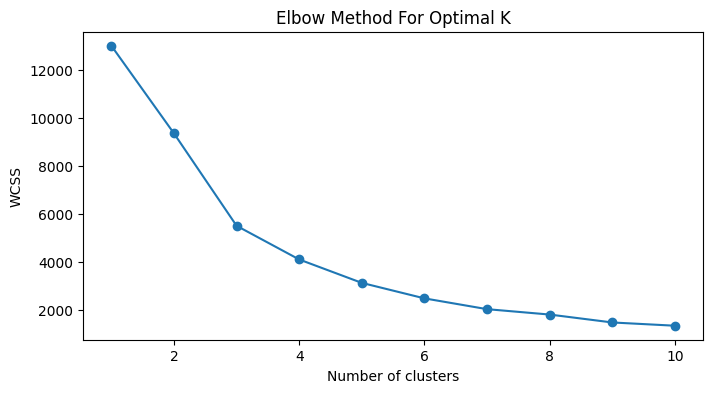

In [8]:
#import libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [9]:
#elbow showed 3 is optimal
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [10]:
rfm['Cluster'].head()

0    1
1    0
2    0
3    0
4    1
Name: Cluster, dtype: int32

## Merging Dataset


In [11]:
# Adding cluster labels to the original dataset
df_with_clusters = df_clean.merge(rfm, on='CustomerID', how='left')

# Check the result
df_with_clusters.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Recency,Frequency,Monetary,Cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,372,34,5391.21,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,372,34,5391.21,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,372,34,5391.21,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,372,34,5391.21,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,372,34,5391.21,1


In [12]:
#name the clusters
cluster_names = {
    2: "VIP Customers",
    0: "Loyal customers",
    1: "Sleeping Customers"
}

df_with_clusters['ClusterName'] = df_with_clusters['Cluster'].map(cluster_names)


In [13]:
# Average RFM values per cluster
cluster_summary1 = df_with_clusters.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'nunique'
}).rename(columns={'CustomerID': 'CustomerCount'}).reset_index()

print(cluster_summary1)

   Cluster     Recency   Frequency      Monetary  CustomerCount
0        0   26.521601   10.619410   5510.789509           3231
1        1  232.370845    2.537801    936.358380           1093
2        2    3.005826  131.271272  93424.496109             14


## RFM Visualization

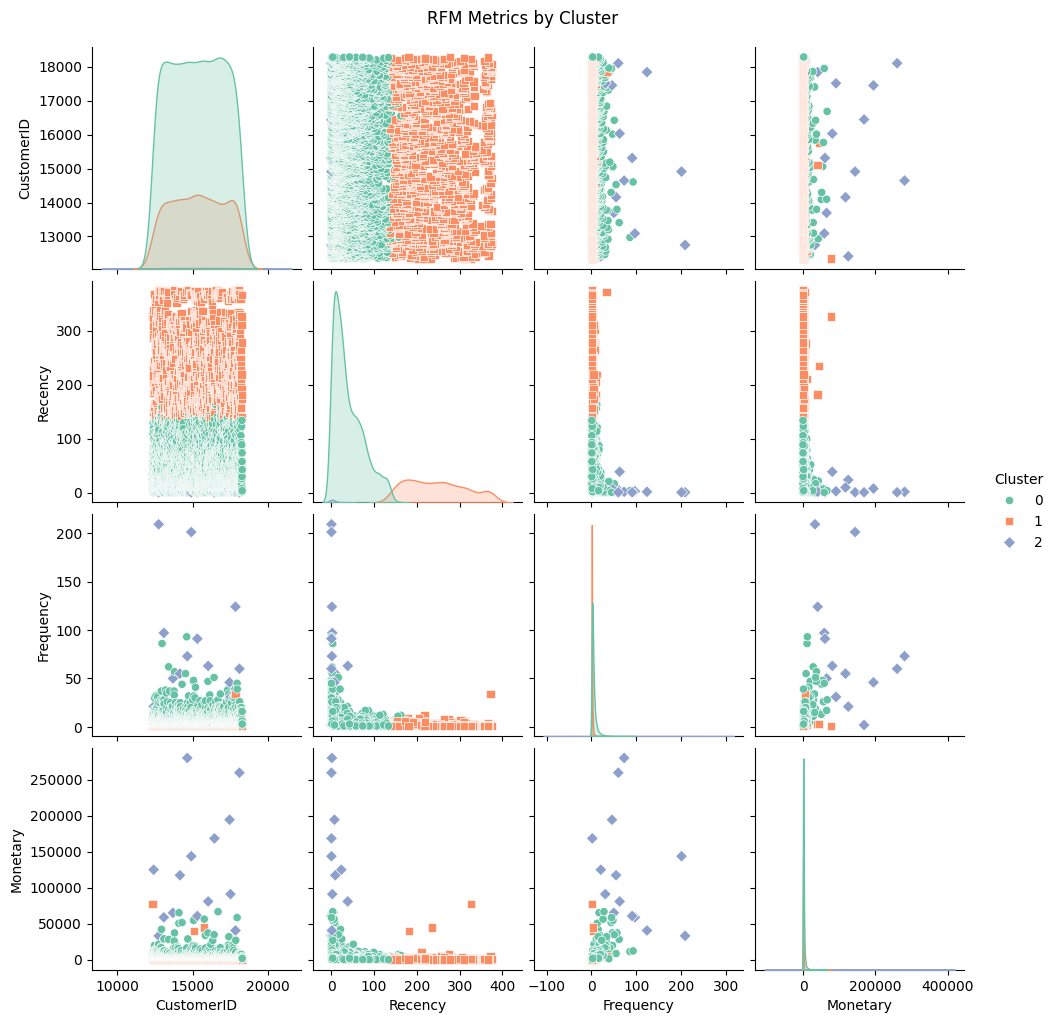

In [14]:
# Distribution of Recency, Frequency, Monetary by Cluster
sns.pairplot(rfm, hue='Cluster', palette='Set2', markers=["o", "s", "D"])
plt.suptitle('RFM Metrics by Cluster', y=1.02)
plt.show()

## Save Dataset

In [15]:
# Save the clustered data to CSV for future use
df_with_clusters.to_csv('customer_with_clusters.csv', index=False)

print("✅ Saved sucessfully")

✅ Saved sucessfully
